In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits import mplot3d
from matplotlib import rcParams
import matplotlib.colors as colors
import copy
import math
import sys
import seaborn as sns
import pandas as pd
from Src import *

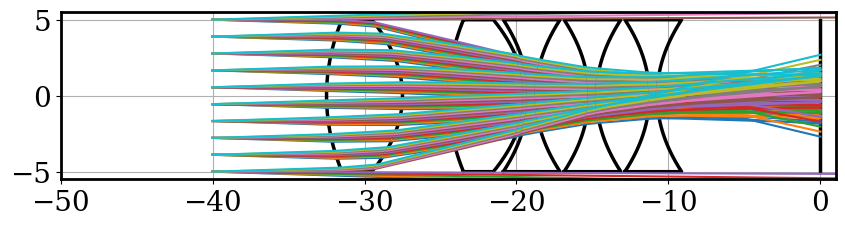

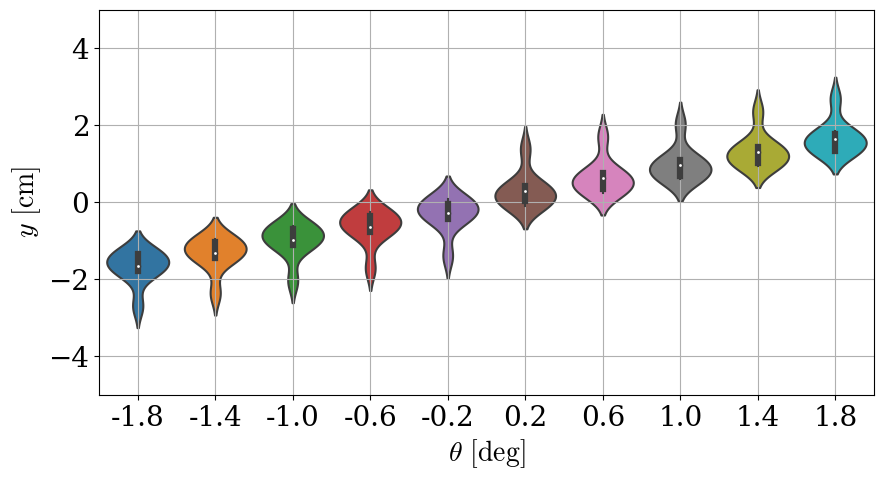

In [97]:
######################################################
###############     USER VARIABLES     ###############
######################################################
verbose = True
plotLenses = True
saveFrames = False
lens_parameters = [ 
                    [ ( -50.0, 25.0, -5, 5 ), 5, 1.98, (  100.0, 25.0, -5, 5 ), -30 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
                    [ ( -50.0, 25.0, -5, 5 ), 5, 1.98, (  100.0, 25.0, -5, 5 ), -22 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
                    [ ( 80, 25.0, -5, 5 ), 0.5, 1.98, ( -80.0, 25.0, -5, 5 ), -19 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
                    [ ( 80, 25.0, -5, 5 ), 0.5, 1.98, ( -80.0, 25.0, -5, 5 ), -11 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
                    [ ( 80, 25.0, -5, 5 ), 0.5, 1.98, ( -80.0, 25.0, -5, 5 ), -15 ], # Lens: (r_x, r_y, y_min, y_max), d, n, (r_x, r_y, y_min, y_max), x_l
                    [ ( 1e-5, 5, 0, -5, 5 ), 1.69, [ -200, 100 ] ]                     # Final Surface: (r_x, r_y, x, y_min, y_max), n, [y_min, y_max]
]

# theta_lim = [ -math.pi/30, math.pi/30, 10 ] # min, max, nPoints
theta_lim = [ -0.008*4, 0.008*4, 10  ] # min, max, nPoints
y_lim     = [ -5      ,      5 , 10  ] # min, max, nPoints
# phi_lim   = [ -math.pi/14, math.pi/14, 5 ] # min, max, nPoints
r         = -40

colors = list(mpl.rcParams['axes.prop_cycle'].by_key()['color'][0:10])
while len(colors) < theta_lim[2]:
    for color in colors[0:10]:
        colors.append(color)

nFrames = theta_lim[2]*y_lim[2]
nPoints = 1000
plotName = 'DPSDtestLens'
nFrames_save = [274,286,304,140]
rayThickness = 1.5
lensColor = 'black' #'lightseagreen'

#######################################################
###############     PLOTTING SCRIPT     ###############
#######################################################

surfaces = []
lenses   = []
for nLens in range(len(lens_parameters)):
    if nLens != len(lens_parameters)-1:
        surfaces.append(surface(lens_parameters[nLens][0][0],lens_parameters[nLens][0][1],
                                lens_parameters[nLens][4] - lens_parameters[nLens][0][0] - lens_parameters[nLens][1]/2,
                                lens_parameters[nLens][0][2],lens_parameters[nLens][0][3],verbose=verbose))
        surfaces.append(surface(lens_parameters[nLens][3][0],lens_parameters[nLens][3][1],
                                lens_parameters[nLens][4] - lens_parameters[nLens][3][0] + lens_parameters[nLens][1]/2,
                                lens_parameters[nLens][3][2],lens_parameters[nLens][3][3],verbose=verbose))
        lenses.append(lens(surfaces[-2],surfaces[-1],lens_parameters[nLens][2],verbose)) 
    else:
        surfaces.append(surface(lens_parameters[nLens][0][0],lens_parameters[nLens][0][1],lens_parameters[nLens][0][2],
                                lens_parameters[nLens][0][3],lens_parameters[nLens][0][4],verbose=verbose))
OS = opticalSystem(lenses,surfaces[-1],lens_parameters[-1][1],verbose)

mpl.rc('font', **{'family' : 'serif', 'size' : 20 })
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['legend.fontsize' ] = 1

fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlim(-50,1)
# ax.set_ylim(-1.4, 1.4)
thickness = 2
ax.spines['left'].set_linewidth(thickness)
ax.spines['bottom'].set_linewidth(thickness)
ax.spines['right'].set_linewidth(thickness)
ax.spines['top'].set_linewidth(thickness)
ax.grid()
ax.set_aspect('equal')

if plotLenses: surfaces_points = OS.get_points_lenses  (nPoints)
else         : surfaces_points = OS.get_points_surfaces(nPoints)

surfaces_plot = []
rays_plot     = []
backPlanePoints = []
for nTheta in range(theta_lim[2]):
    rays_plot.append([])
    for nY in range(y_lim[2]):
        rays_plot[nTheta].append([])
if plotLenses:
    for nLens in range(len(lenses)+1):
        surfaces_plot.append(ax.plot([x for x,y in surfaces_points[nLens]], [y for x,y in surfaces_points[nLens]], color=lensColor, linewidth=2.5)[0])
for nSurface in range(len(surfaces)):
    if not plotLenses: surfaces_plot.append(ax.plot([x for x,y in surfaces_points[nSurface]], [y for x,y in surfaces_points[nSurface]], color=lensColor, linewidth=2.5)[0])
    if nSurface < len(surfaces):
        for nRays in range(len(rays_plot)):
            for ray in rays_plot[nRays]:
                ray.append(ax.plot([],[],linewidth=rayThickness,color=colors[nRays])[0])
        
for nFrame in range(nFrames):
    nFrame_theta = nFrame // y_lim[2]
    nFrame_y     = nFrame - nFrame_theta * y_lim[2]

    theta      = theta_lim[0] + ( theta_lim[1] - theta_lim[0] ) / (theta_lim[2]-1) * nFrame_theta
    y          = y_lim[0] + (y_lim[1] - y_lim[0])/(y_lim[2]-1)*nFrame_y
    OR         = opticalRay(r,y,theta)
    RP         = rayPropagator(OS,OR,lens_parameters[-1][2])  
    points_ray = RP.propagateRay()
    points_ray_formatted = []
    for nPoint in range(len(points_ray)-1):
        points_ray_formatted.append(([points_ray[nPoint].x,points_ray[nPoint+1].x],[points_ray[nPoint].y,points_ray[nPoint+1].y]))
    backPlanePoints.append((theta, points_ray_formatted[-1][1][1]))

    for nRay in range(len(rays_plot[nFrame_theta][nFrame_y])):
        rays_plot[nFrame_theta][nFrame_y][nRay].set_data(points_ray_formatted[nRay][0], points_ray_formatted[nRay][1])
            
plt.savefig('DSPDtestLens.pdf',bbox_inches='tight')
plt.show()


theta_values = []
y_values     = []
for theta,y in backPlanePoints:
    if abs(y) <= 5:
        theta_values.append(theta)
        y_values    .append(y)
data = pd.DataFrame({"theta": theta_values, "y": y_values})
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(data=data,x='theta',y='y')
ax.set_xlabel(r'$\theta$ $\mathrm{[deg]}$')
ax.set_ylabel(r'$y$ $\mathrm{[cm]}$')
ax.set_ylim(-5, 5)
unique_thetas = sorted(set(theta_values))
ax.set_xticks(range(len(unique_thetas)))
formatted_labels = ["{:.1f}".format(theta * 180 / math.pi) for theta in unique_thetas]
ax.set_xticklabels(formatted_labels)
ax.grid()
plt.show()